In [9]:
import pylab as p

from nepal.datasets import (
    NYTimes,
    Vaccinations,
    CountyDistance,
    GovernmentResponse,
    PopulationDensity,
)

from nepal.ml.preprocess import Cases

In [4]:
nytimes = NYTimes().load()

In [ ]:
vaccinations = Vaccinations().load()

In [ ]:
distances = CountyDistance(radius=100).load()

In [ ]:
response_tracker = GovernmentResponse().load()

In [2]:
population_density = PopulationDensity().load()

Average Household Size and Population Density - County:   0%|          | 0.00/225k [00:00<?, ?B/s]

In [12]:
df = Cases(NYTimes()).preprocessed()
df

county           state  cases  deaths  new_cases  \
fips  date                                                               
01001 2020-01-21     Autauga         Alabama      0       0          0   
      2020-01-22     Autauga         Alabama      0       0          0   
      2020-01-23     Autauga         Alabama      0       0          0   
      2020-01-24     Autauga         Alabama      0       0          0   
      2020-01-25     Autauga         Alabama      0       0          0   
...                      ...             ...    ...     ...        ...   
78030 2022-04-07  St. Thomas  Virgin Islands   7206      59          7   
      2022-04-08  St. Thomas  Virgin Islands   7219      59         13   
      2022-04-09  St. Thomas  Virgin Islands   7219      59          0   
      2022-04-10  St. Thomas  Virgin Islands   7219      59          0   
      2022-04-11  St. Thomas  Virgin Islands   7219      59          0   

                  new_deaths  
fips  date                    
01001 2020-01-21           0  
      2020-01-22           0  
      2020-01-23           0  
      2020-01-24           0  
      2020-01-25           0  
...                      ...  
78030 2022-04-07           0  
      2022-04-08           0  
      2022-04-09           0  
      2022-04-10           0  
      2022-04-11           0  

[2614640 rows x 6 columns]

<AxesSubplot:>

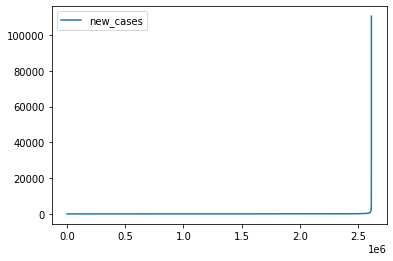

In [25]:
df.reset_index()[["new_cases"]].sort_values(by="new_cases").reset_index(drop=True).plot()

In [27]:
df[df["new_cases"] == df["new_cases"].max()]

,,county,state,cases,deaths,new_cases,new_deaths
fips,date,,,,,,
12086,2022-01-07,Miami-Dade,Florida,958187,9278,110441,0


In [32]:
df[df.index.get_level_values("fips") == "12086"]

county    state    cases  deaths  new_cases  new_deaths
fips  date                                                                   
12086 2020-01-21  Miami-Dade  Florida        0       0          0           0
      2020-01-22  Miami-Dade  Florida        0       0          0           0
      2020-01-23  Miami-Dade  Florida        0       0          0           0
      2020-01-24  Miami-Dade  Florida        0       0          0           0
      2020-01-25  Miami-Dade  Florida        0       0          0           0
...                      ...      ...      ...     ...        ...         ...
      2022-04-07  Miami-Dade  Florida  1176694   10800          0           0
      2022-04-08  Miami-Dade  Florida  1182222   10800       5528           0
      2022-04-09  Miami-Dade  Florida  1182222   10800          0           0
      2022-04-10  Miami-Dade  Florida  1182222   10800          0           0
      2022-04-11  Miami-Dade  Florida  1182222   10800          0           0

[812 rows x 6 columns]

In [53]:
from abc import ABC, abstractmethod
from typing import Iterable, Mapping, Sequence

import pandas as pd

from nepal.datasets import Dataset, NYTimes, PopulationDensity


class Preprocessor(ABC):
    @abstractmethod
    def preprocessed(self) -> pd.DataFrame:
        raise NotImplementedError


class Cases(Preprocessor):
    def __init__(self, dataset: NYTimes) -> None:
        self._dataset: Dataset = dataset

        self._index: Sequence[str] = ["fips", "date"]
        self._targets: Sequence[str] = ["cases", "deaths"]

    def preprocessed(self) -> pd.DataFrame:
        df_covid: pd.DataFrame = self._dataset.load()

        return (
            df_covid.dropna(subset=self._index)
            .set_index(self._index)
            .pipe(self._fill_index, names=self._index)
            .sort_index(level=self._index)
            .pipe(self._cast_types_as_signed, cols=self._targets)
            .pipe(self._calculate_new, cols=self._targets)
        )

    @classmethod
    def _fill_index(cls, df: pd.DataFrame, names: Sequence[str]) -> pd.DataFrame:
        return df.pipe(cls._complete_index, names=names).pipe(cls._fill_na)

    @classmethod
    def _complete_index(cls, df: pd.DataFrame, names: Sequence[str]) -> pd.DataFrame:
        dates: pd.Index = df.index.get_level_values("date")

        labels: Mapping[str, pd.Index] = {
            "fips": df.index.get_level_values("fips").unique(),
            "date": pd.date_range(start=dates.min(), end=dates.max(), freq="D"),
        }

        complete: pd.MultiIndex = pd.MultiIndex.from_product(
            [labels[names[0]], labels[names[1]]], names=names
        )

        return df.reindex(complete)

    @classmethod
    def _fill_na(cls, df: pd.DataFrame) -> pd.DataFrame:
        return df.assign(
            county=df.county.bfill(),
            state=df.state.bfill(),
            cases=df.cases.fillna(0),
            deaths=df.deaths.fillna(0),
        )

    @classmethod
    def _cast_types_as_signed(cls, df: pd.DataFrame, cols: Iterable[str]) -> pd.DataFrame:
        return df.astype({col: "int64" for col in cols})

    @classmethod
    def _calculate_new(cls, df: pd.DataFrame, cols: Iterable[str]) -> pd.DataFrame:
        for col in cols:
            diff: pd.Series = df.groupby(level="fips")[col].diff().fillna(0)
            avg: pd.Series = diff.groupby(level="fips").apply(
                lambda x: x.rolling(7, min_periods=1).mean()
            )
            df[f"new_{col}"] = avg.clip(0)
        return df

In [54]:
df = Cases(NYTimes()).preprocessed()
df

county           state  cases  deaths  new_cases  \
fips  date                                                               
01001 2020-01-21     Autauga         Alabama      0       0   0.000000   
      2020-01-22     Autauga         Alabama      0       0   0.000000   
      2020-01-23     Autauga         Alabama      0       0   0.000000   
      2020-01-24     Autauga         Alabama      0       0   0.000000   
      2020-01-25     Autauga         Alabama      0       0   0.000000   
...                      ...             ...    ...     ...        ...   
78030 2022-04-07  St. Thomas  Virgin Islands   7206      59   9.714286   
      2022-04-08  St. Thomas  Virgin Islands   7219      59  10.571429   
      2022-04-09  St. Thomas  Virgin Islands   7219      59  10.571429   
      2022-04-10  St. Thomas  Virgin Islands   7219      59  10.571429   
      2022-04-11  St. Thomas  Virgin Islands   7219      59  10.571429   

                  new_deaths  
fips  date                    
01001 2020-01-21         0.0  
      2020-01-22         0.0  
      2020-01-23         0.0  
      2020-01-24         0.0  
      2020-01-25         0.0  
...                      ...  
78030 2022-04-07         0.0  
      2022-04-08         0.0  
      2022-04-09         0.0  
      2022-04-10         0.0  
      2022-04-11         0.0  

[2614640 rows x 6 columns]

In [59]:
df[df["new_cases"] == df["new_cases"].min()]

county           state  cases  deaths  new_cases  \
fips  date                                                               
01001 2020-01-21     Autauga         Alabama      0       0        0.0   
      2020-01-22     Autauga         Alabama      0       0        0.0   
      2020-01-23     Autauga         Alabama      0       0        0.0   
      2020-01-24     Autauga         Alabama      0       0        0.0   
      2020-01-25     Autauga         Alabama      0       0        0.0   
...                      ...             ...    ...     ...        ...   
78030 2021-03-20  St. Thomas  Virgin Islands   1373      15        0.0   
      2021-03-21  St. Thomas  Virgin Islands   1373      15        0.0   
      2021-03-22  St. Thomas  Virgin Islands   1373      15        0.0   
      2021-03-23  St. Thomas  Virgin Islands   1373      15        0.0   
      2021-04-04  St. Thomas  Virgin Islands   1418      15        0.0   

                  new_deaths  
fips  date                    
01001 2020-01-21         0.0  
      2020-01-22         0.0  
      2020-01-23         0.0  
      2020-01-24         0.0  
      2020-01-25         0.0  
...                      ...  
78030 2021-03-20         0.0  
      2021-03-21         0.0  
      2021-03-22         0.0  
      2021-03-23         0.0  
      2021-04-04         0.0  

[409247 rows x 6 columns]

<AxesSubplot:ylabel='Density'>

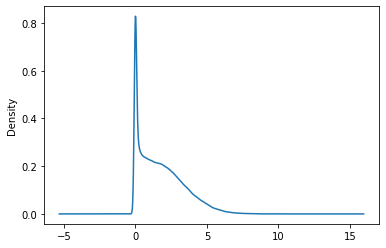

In [63]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(
    func=np.log1p,
    inverse_func=np.expm1,
)

pd.Series(log_transformer.transform(df["new_cases"])).plot.density()